# Initial Data Understanding



## Loading Data and Libraries

In [1]:
import unidecode
import os
import sys
import sys

sys.path.append('../src/')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Preprocessamento dos dados de informações municipais


Antes de iniciar a análise exploratória dos dados, temos que limpar e transformar os dados que foram nos dados. Os arquivos são um csv com wide format onde as colunas são os meses e as linhas os municípios. Vou unpivotar a tabela, já que trabalhamos melhor em long format com dados temporais. Também, percebemos que diversos arquivos contém a mesma estrutura, o que faz sentido, já que apresentam basicamente a mesma informação. Portanto, irei concatená-los em um único arquivo e dataframe para facilitar o nosso processo.

In [2]:
# arquivos que serao concatenados
files_to_concat = [file  for file in os.listdir('../data/raw/') 
                   if file.startswith('equipes') or file.startswith('rf') or file.startswith('rh')]
files_to_concat

['rf_tomografos_computadorizados.csv',
 'rf_mamografos.csv',
 'rfressonancia_magnetica.csv',
 'equipes_de_saude_equipes_saude_da_familia.csv',
 'rh_medicos.csv',
 'equipes_de_saude_nucleos_de_apoio_a_saude_da_familia_nasf.csv',
 'rf_leitos_de_internacao.csv',
 'rh_enfermeiros.csv',
 'rf_raios_x.csv']

Criamos algumas funções auxiliares para nos ajudar na tarefa.

In [3]:
import preprocess

df_combined = preprocess.combine(files_to_concat)

In [4]:
df_combined.head(5)

,municipio_rf_tomografos_computadorizados,data_rf_tomografos_computadorizados,rf_tomografos_computadorizados,municipio_rf_mamografos,data_rf_mamografos,rf_mamografos,municipio_rfressonancia_magnetica,data_rfressonancia_magnetica,rfressonancia_magnetica,municipio_equipes_de_saude_equipes_saude_da_familia,...,equipes_de_saude_nucleos_de_apoio_a_saude_da_familia_nasf,municipio_rf_leitos_de_internacao,data_rf_leitos_de_internacao,rf_leitos_de_internacao,municipio_rh_enfermeiros,data_rh_enfermeiros,rh_enfermeiros,municipio_rf_raios_x,data_rf_raios_x,rf_raios_x
0,110001 Alta Floresta D'Oeste,2014/jan,-,110001 Alta Floresta D'Oeste,2014/jan,-,110001 Alta Floresta D'Oeste,2014/jan,-,110001 Alta Floresta D'Oeste,...,1,110001 Alta Floresta D'Oeste,2014/jan,45,110001 Alta Floresta D'Oeste,2014/jan,14,110001 Alta Floresta D'Oeste,2014/jan,1
1,110037 Alto Alegre dos Parecis,2014/jan,-,110037 Alto Alegre dos Parecis,2014/jan,-,110037 Alto Alegre dos Parecis,2014/jan,-,110037 Alto Alegre dos Parecis,...,1,110037 Alto Alegre dos Parecis,2014/jan,16,110037 Alto Alegre dos Parecis,2014/jan,6,110037 Alto Alegre dos Parecis,2014/jan,-
2,110040 Alto Paraíso,2014/jan,-,110040 Alto Paraíso,2014/jan,-,110040 Alto Paraíso,2014/jan,-,110040 Alto Paraíso,...,-,110040 Alto Paraíso,2014/jan,15,110040 Alto Paraíso,2014/jan,7,110040 Alto Paraíso,2014/jan,1
3,110034 Alvorada D'Oeste,2014/jan,-,110034 Alvorada D'Oeste,2014/jan,-,110034 Alvorada D'Oeste,2014/jan,-,110034 Alvorada D'Oeste,...,-,110034 Alvorada D'Oeste,2014/jan,35,110034 Alvorada D'Oeste,2014/jan,10,110034 Alvorada D'Oeste,2014/jan,1
4,110002 Ariquemes,2014/jan,1,110002 Ariquemes,2014/jan,1,110002 Ariquemes,2014/jan,1,110002 Ariquemes,...,1,110002 Ariquemes,2014/jan,85,110002 Ariquemes,2014/jan,54,110002 Ariquemes,2014/jan,4


Ao analisar com mais detalhe o dado, vimos que para alguns arquivos, temos informações até agosto de 2019, sendo assim, temos que tomar cuidado para não dropar linhas de arquivos que contém essas informações. Vamos manter aquela coluna de data que contém o maior número de informações não nulas.

In [5]:
df_combined.isnull().sum(0)

municipio_rf_tomografos_computadorizados                               44776
data_rf_tomografos_computadorizados                                    44776
rf_tomografos_computadorizados                                         44776
municipio_rf_mamografos                                                44776
data_rf_mamografos                                                     44776
rf_mamografos                                                          44776
municipio_rfressonancia_magnetica                                      44776
data_rfressonancia_magnetica                                           44776
rfressonancia_magnetica                                                44776
municipio_equipes_de_saude_equipes_saude_da_familia                        0
data_equipes_de_saude_equipes_saude_da_familia                             0
equipes_de_saude_equipes_saude_da_familia                                  0
municipio_rh_medicos                                                   44776

In [9]:
columns_to_keep = [col for col in df_combined.columns if not col.startswith('municipio')
                  and not col.startswith('data')]

columns_to_keep += ['municipio_equipes_de_saude_equipes_saude_da_familia',
                    'data_equipes_de_saude_equipes_saude_da_familia']

In [10]:
df_final = df_combined[columns_to_keep].copy()
df_final = df_final.rename(columns={
    'municipio_equipes_de_saude_equipes_saude_da_familia': 'municipio',
    'data_equipes_de_saude_equipes_saude_da_familia': 'data'
})

df_final.shape

(380596, 11)

Pronto, temos um dado mais normalizado e limpo, porém temos mais alguns ajustes a fazer. Valores que contém hífen são aqueles que não obtivemos números, então irei substituílos por zero.

In [11]:
df_final = df_final.replace('-', 0)

In [12]:
# cols to conver
columns_to_convert = [col for col in df_final.columns 
                      if col not in ['municipio', 'data']]

In [13]:
df_final[columns_to_convert] = df_final[columns_to_convert].astype(np.float)

Por fim, irei normalizar os valores de municipio, bem como criar uma coluna extra com o código do mesmo, assim conseguimos cruzar depois com dados da APAC.

In [41]:
df_final[['cod_municipio', 'nom_municipio']].values[:6]

array([[11000, "Alta Floresta D'Oeste"],
       [11003, 'Alto Alegre dos Parecis'],
       [11004, 'Alto Paraíso'],
       [11003, "Alvorada D'Oeste"],
       [11000, 'Ariquemes'],
       [11004, 'Buritis']], dtype=object)

In [51]:
list(map((lambda x: x[0]), 'AB'))

['A', 'B']

In [53]:
import re

regex = re.compile(r'\w+')
regex.findall("11000 Alta Floresta D'Oeste")

['11000', 'Alta', 'Floresta', 'D', 'Oeste']

In [58]:
df_final.municipio.apply(lambda x: x.split()[0], x.split()[1])

NameError: name 'x' is not defined

In [59]:
df_final['cod_municipio'] = df_final.municipio.apply(lambda x: x.split()[0]).astype(int)
df_final['nom_municipio'] = df_final.municipio.apply(lambda x: x.split()[1])

In [16]:
# salvando arquivo para nao precisar processar novamente
df_final.to_csv('../data/preprocessed/recursos_fis_hum_equi.csv', index=False)

## Análise Exploratória

Vemos que a estrutura do nosso dado é temporal, ela apresenta então três grupos diferentes de características:

 - Para aqueles arquivos/colunas que começam com rf, temos a quantidade de recursos físicos encontrados no munícipio por data, isto é, estes recursos físicos contam coisas como: 
     - Leitos de Internação
     - Ressonância Magnética
     - Mamógrafos
     - Tomografias Computadorizadas
     - Aparelhos de Raio-X
 - Já para aqueles iniciados com rf, temos a quantidade de recursos humanos dispoíveis, entre eles:
     - Enfermeiros
     - Médicos
 - E por fim, equipes de saúde da família:
     - Equipe de Saúda da Família
     - Equipe de Saúda da Família - NASF Modalidade 1
     
Vamos começar a entender estes dados através de uma análise dos dados disponíveis neste conjunto, depois de termos um conhecimento mais aprofundado deste, iremos partir para cruzamentos com os dados da apac.

#### Número de Médicos (Média) por Município

In [65]:
shapefile.codigo_ibg

0       4106803
1       4107009
2       2706604
3       2505204
4       4128633
         ...   
5559    3554300
5560    3554755
5561    3555406
5562    3555505
5563    3555604
Name: codigo_ibg, Length: 5564, dtype: object

In [66]:
import geopandas as gpd

gdf = gpd.read_file('../data/external/shapefile_municipios/municipios_2010.shp',
                         encoding='latin-1')
gdf['cod_municipio'] = gdf.codigo_ibg.apply(lambda x: x[:-1]).astype(int)
gdf.head(10)

,id,nome,uf,populacao,pib,estado_id,codigo_ibg,geometry,cod_municipio
0,3284,Cruz Machado,PR,18040,145687,18,4106803,POLYGON ((-50.98167953708689 -25.6657194057046...,410680
1,3287,Curiúva,PR,13923,127042,18,4107009,POLYGON ((-50.36107073307947 -23.8822439964929...,410700
2,94,Paulo Jacinto,AL,7426,27235,2,2706604,POLYGON ((-36.36575491835766 -9.36100866164145...,270660
3,2629,Cuitegi,PB,6889,29196,15,2505204,POLYGON ((-35.47235871306991 -6.92276896015657...,250520
4,3294,Doutor Ulysses,PR,5727,103024,18,4128633,POLYGON ((-49.24020564514738 -24.4215293424303...,412863
5,3296,Engenheiro Beltrão,PR,13906,226156,18,4107504,POLYGON ((-52.22175092546676 -23.6506552230060...,410750
6,1346,Abadia dos Dourados,MG,6704,79223,11,3100104,POLYGON ((-47.44409846171362 -18.1584651772434...,310010
7,88,Palestina,AL,5112,17231,2,2706208,POLYGON ((-37.30271320555262 -9.63560398450713...,270620
8,2505,Paragominas,PA,97819,1235379,14,1505502,POLYGON ((-46.73064010537637 -2.41625703147063...,150550
9,1347,Abaeté,MG,22690,260389,11,3100203,POLYGON ((-45.18200432744472 -18.8875672971363...,310020


In [68]:
grouped_mun_enf = df_final.groupby('cod_municipio').rh_enfermeiros.mean().reset_index()
grouped_mun_enf

,cod_municipio,rh_enfermeiros
0,0,0.000000
1,110000,0.000000
2,110001,16.666667
3,110002,70.766667
4,110003,4.683333
...,...,...
5592,522200,9.583333
5593,522205,6.300000
5594,522220,5.266667
5595,522230,3.066667


In [75]:
np.percentile(grouped_mun_enf.rh_enfermeiros.values, [5, 95])

array([ 1.68333333, 99.73      ])

In [82]:
t = grouped_mun_enf.copy()
t['rh'] = t.rh_enfermeiros.where(t.rh_enfermeiros < 99, 100)

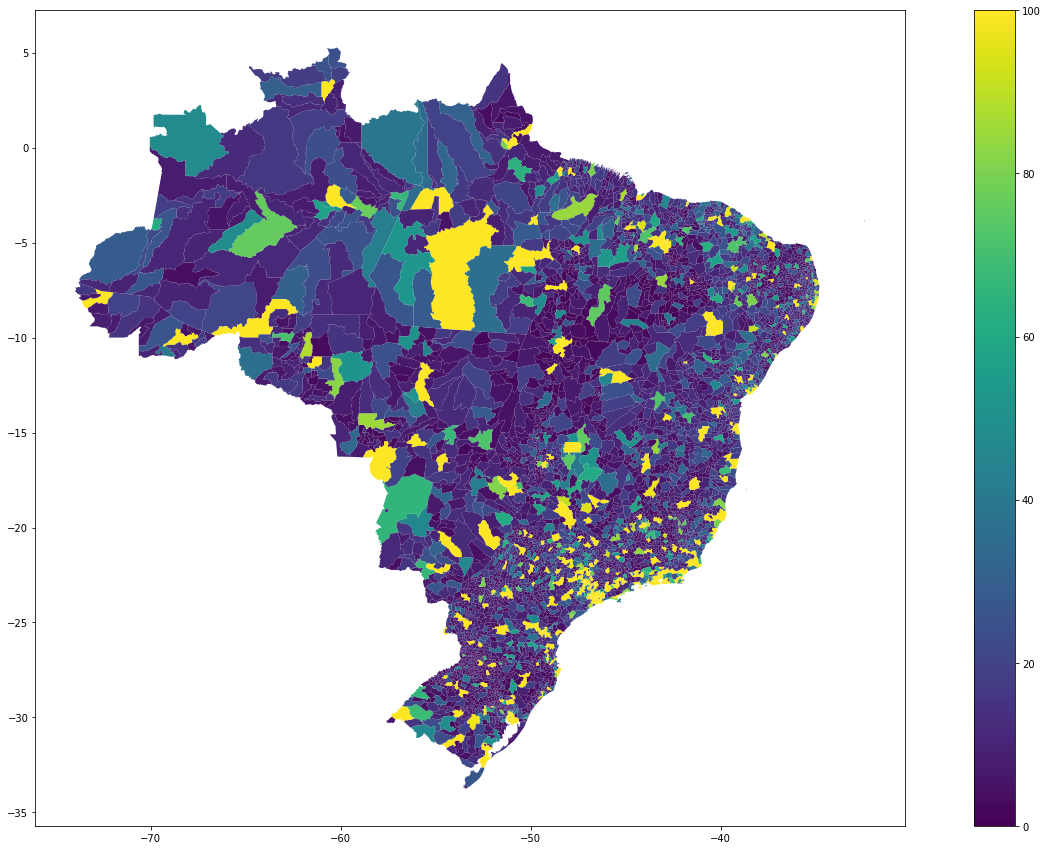

In [83]:
fig, ax = plt.subplots(figsize=(25, 15))

mask = (grouped_mun_enf.rh_enfermeiros>=1.68) & (grouped_mun_enf.rh_enfermeiros<=100)
gdf.merge(t, on='cod_municipio').plot(column='rh',
                                                   ax=ax,
                                                   legend=True)